<a href="https://colab.research.google.com/github/eTeReBeReTe/Stock-Price-Prediction-using-LSTM-and-Technical-Indicators/blob/main/Price%20Prediction%20using%20LSTM%20and%20TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import yfinance as yf

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset

def load_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(start=START, end=TODAY, auto_adjust = False)
    #data = yf.download(ticker, START, TODAY)
    data['Company Name'] = stock.info['longName']
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.tz_localize(None)  # drop the timezone
    #data['Date'] = data['Date'].dt.date                # cast to plain date
    # **make Date the index**
    data.set_index('Date', inplace=True)
    return data

In [ ]:
df = load_data('NVDA')
data=df.drop(columns=["Dividends", "Stock Splits"])
data.head()

,Open,High,Low,Close,Adj Close,Volume,Company Name
Date,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,"Tesla, Inc."
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,"Tesla, Inc."
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,"Tesla, Inc."
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,"Tesla, Inc."
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,"Tesla, Inc."


In [ ]:
#data = web.get_data_yahoo('TSLA', start = datetime.datetime(2000, 1, 2), end = date.today())
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [ ]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3752 number of days in the dataset.


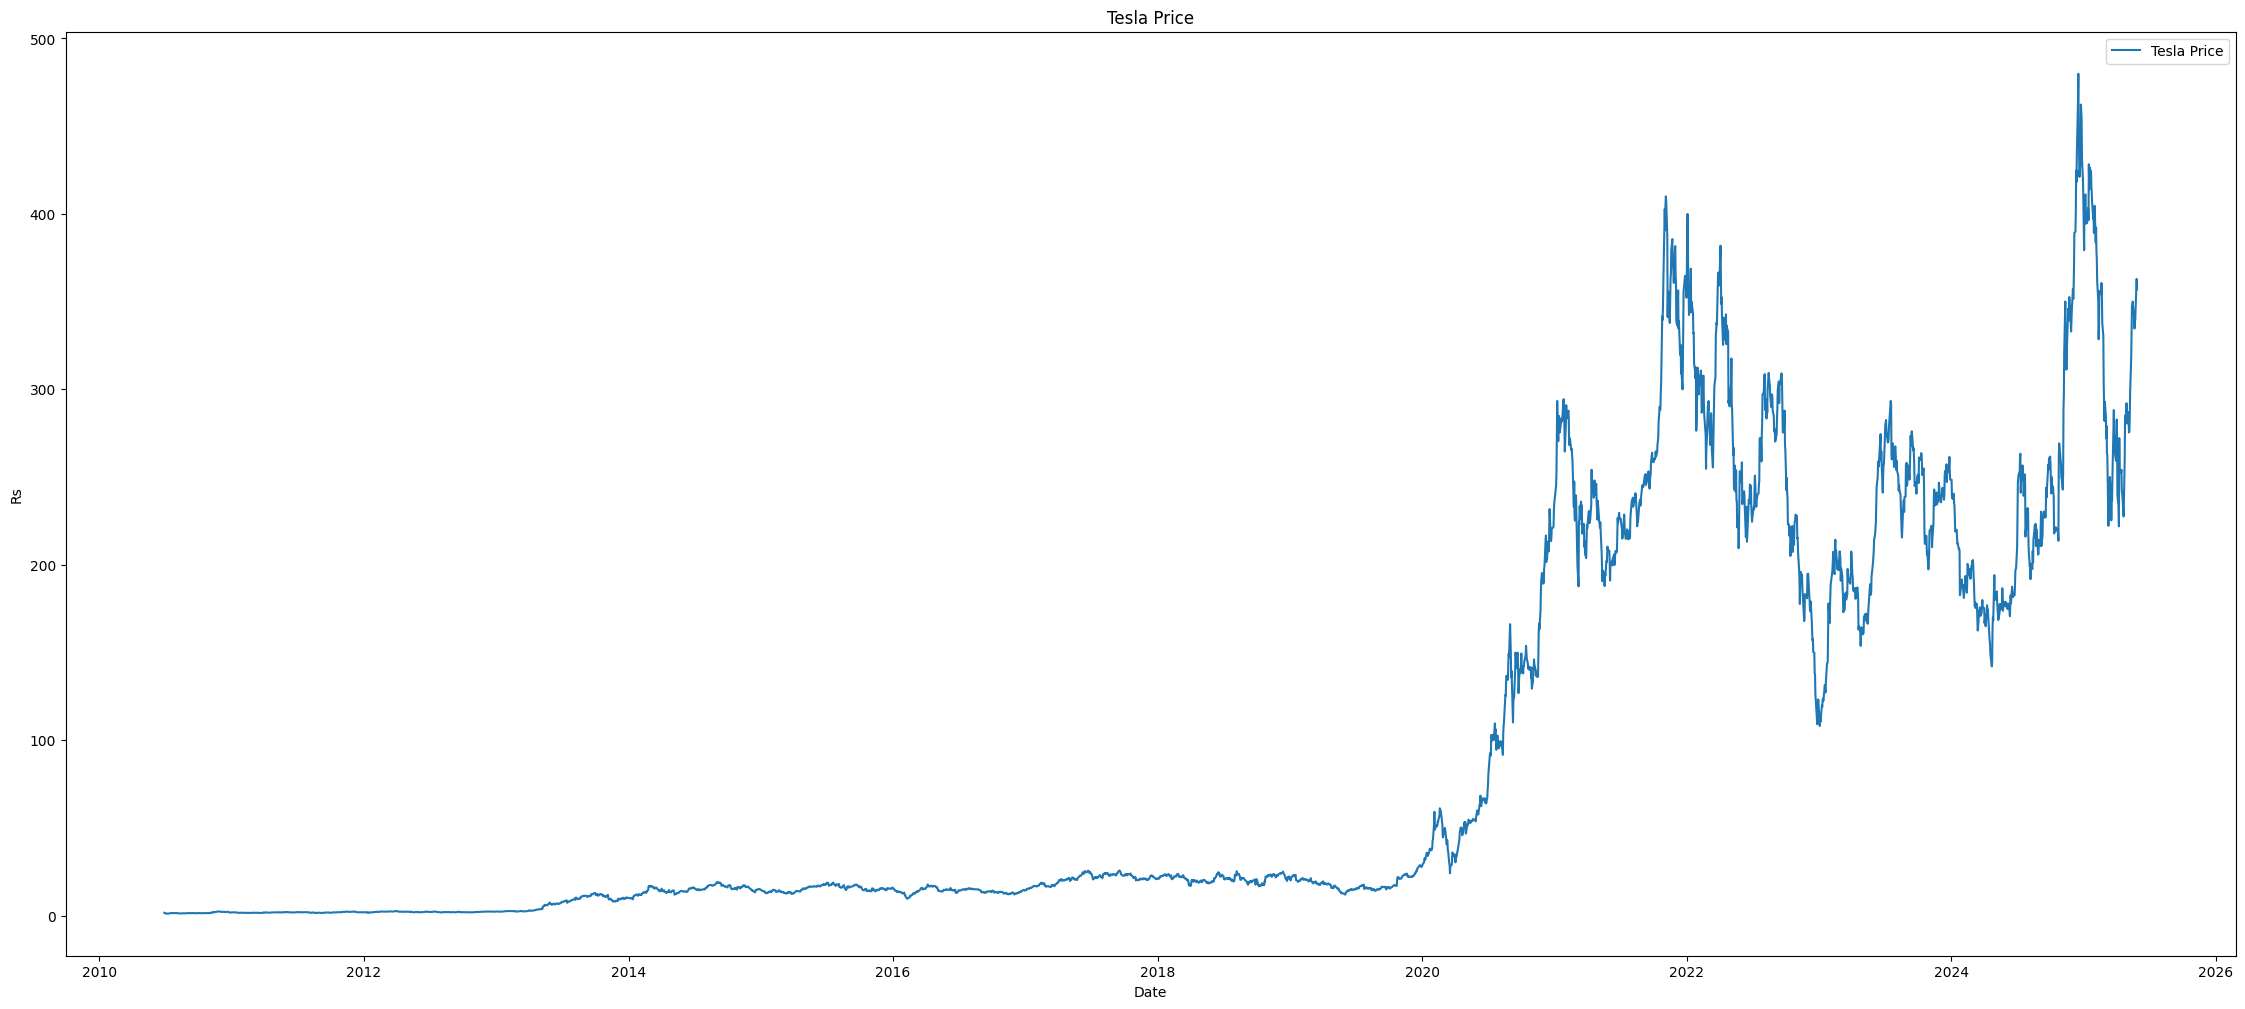

In [ ]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Nvidia Price')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('Tesla Price')
plt.legend()
plt.show()

In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [ ]:
df = get_technical_indicators(data)

In [ ]:
df = df.dropna()
df.head()

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Tesla - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

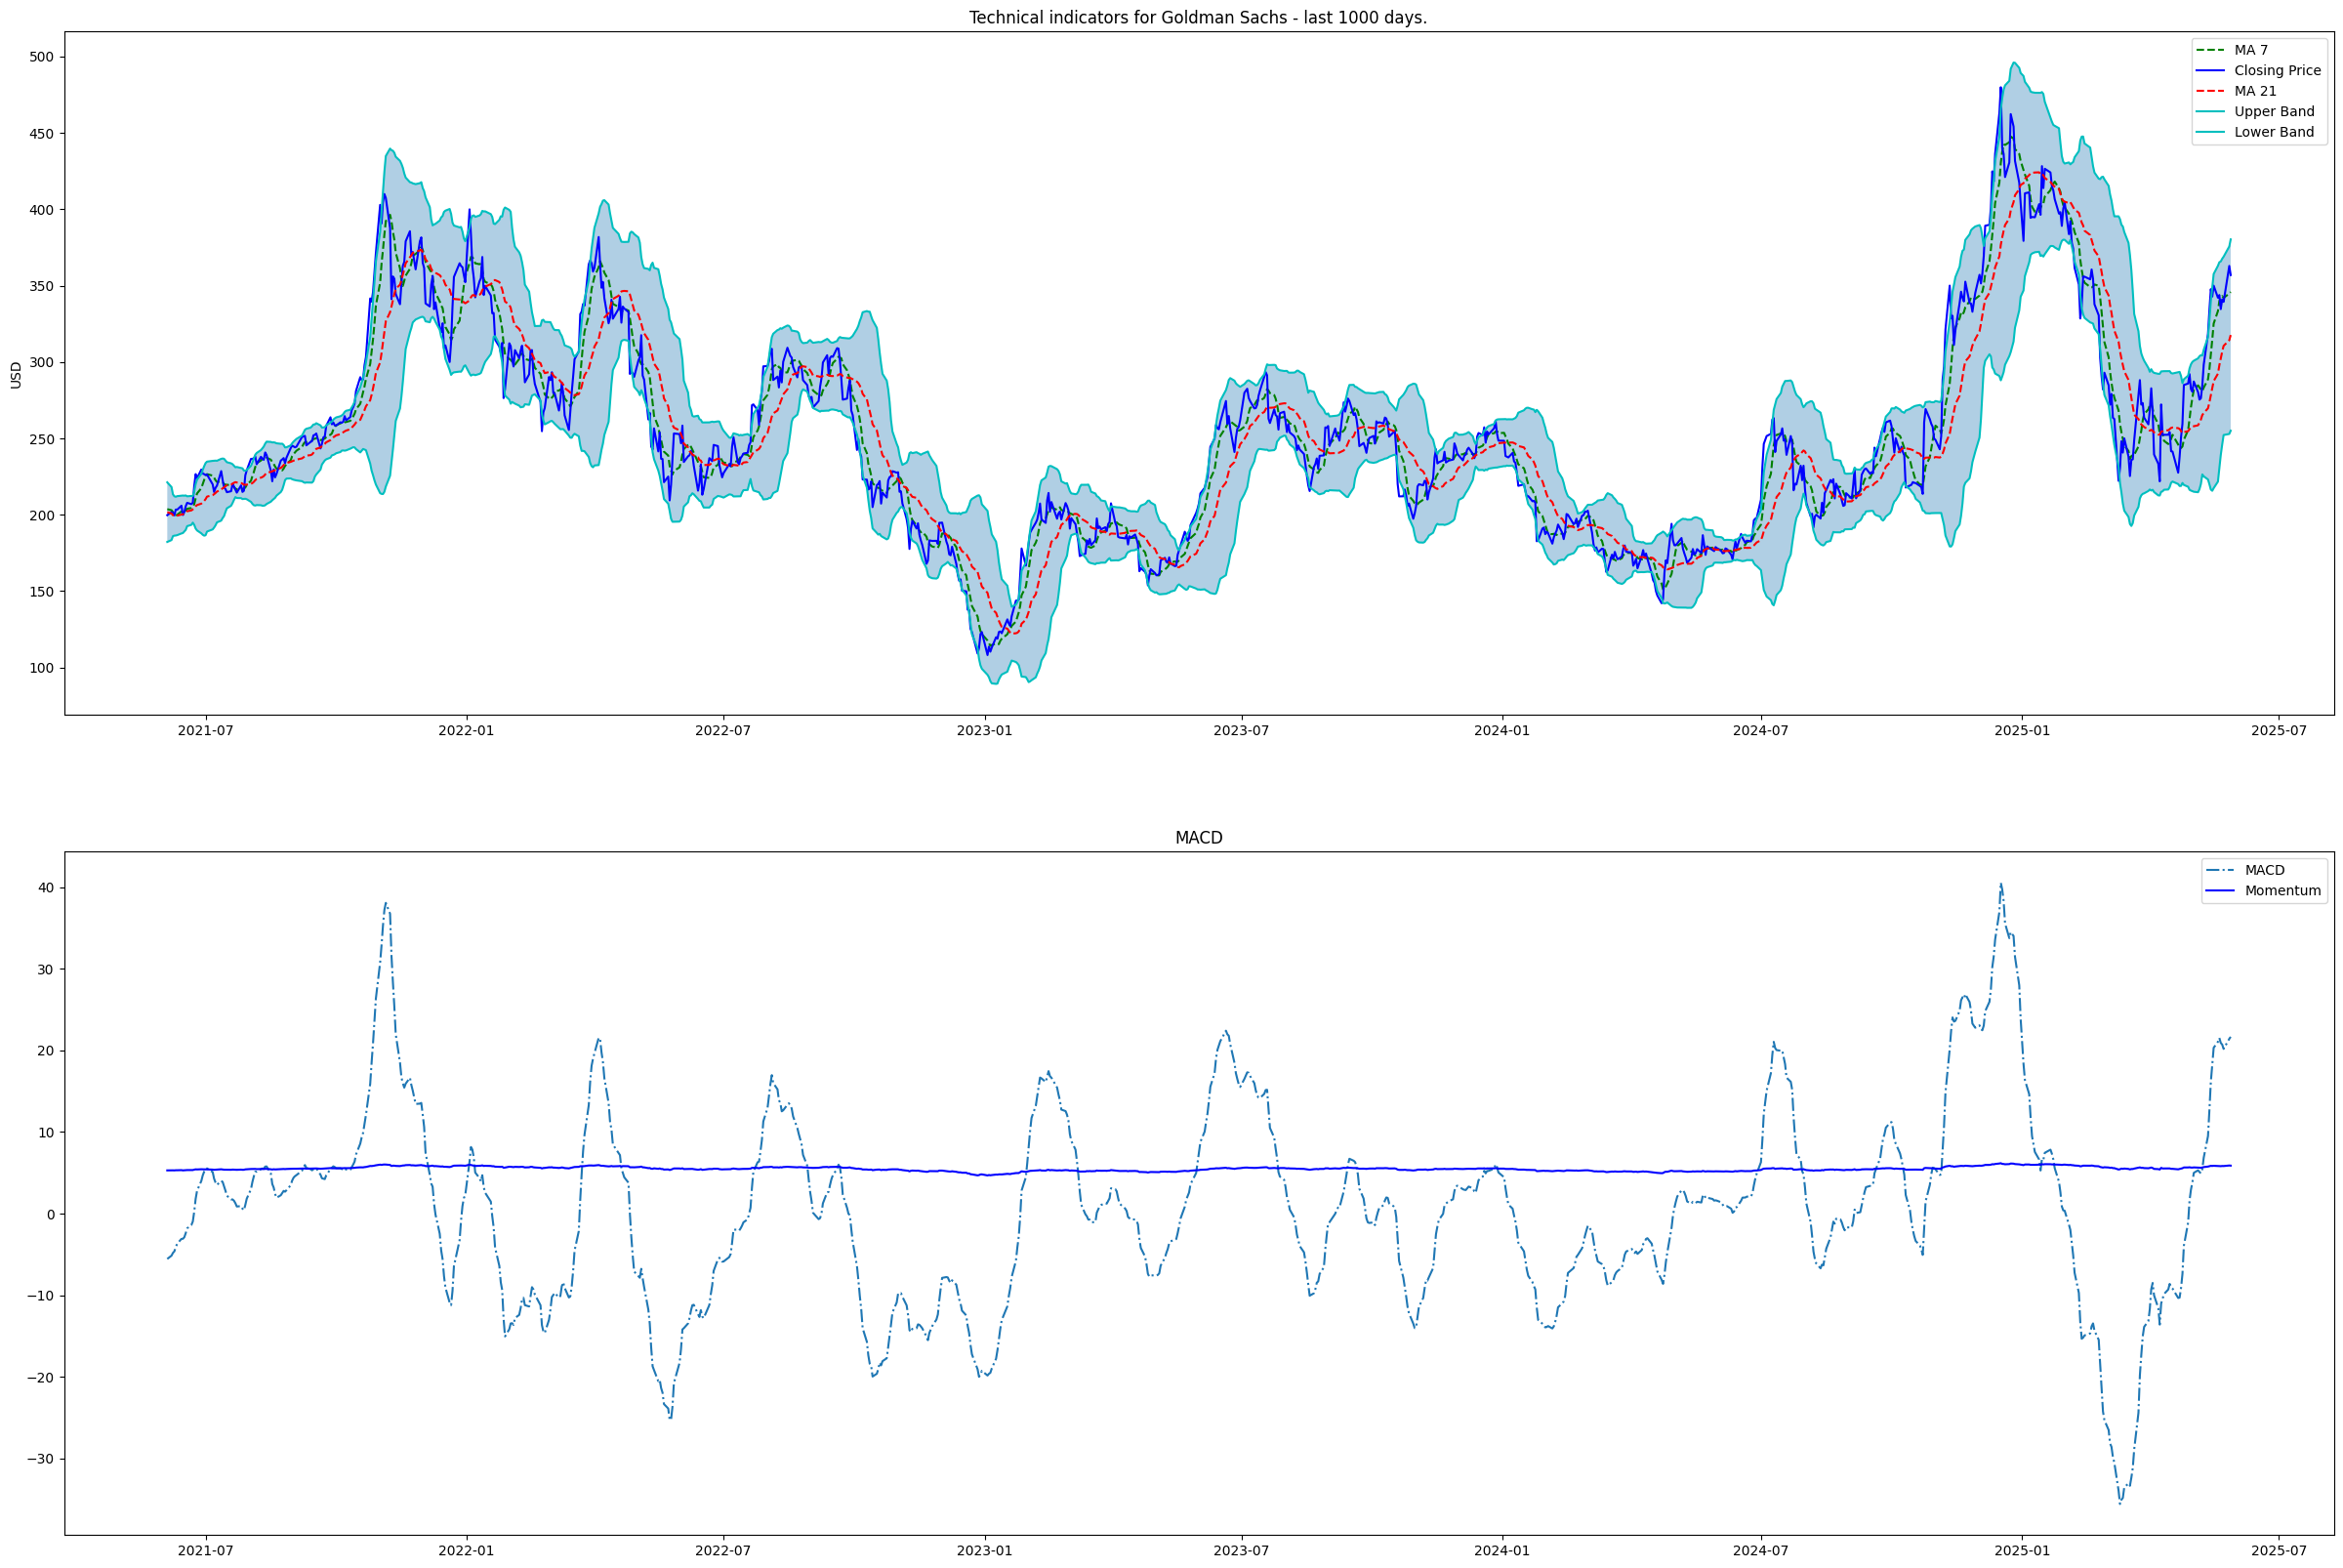

In [ ]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

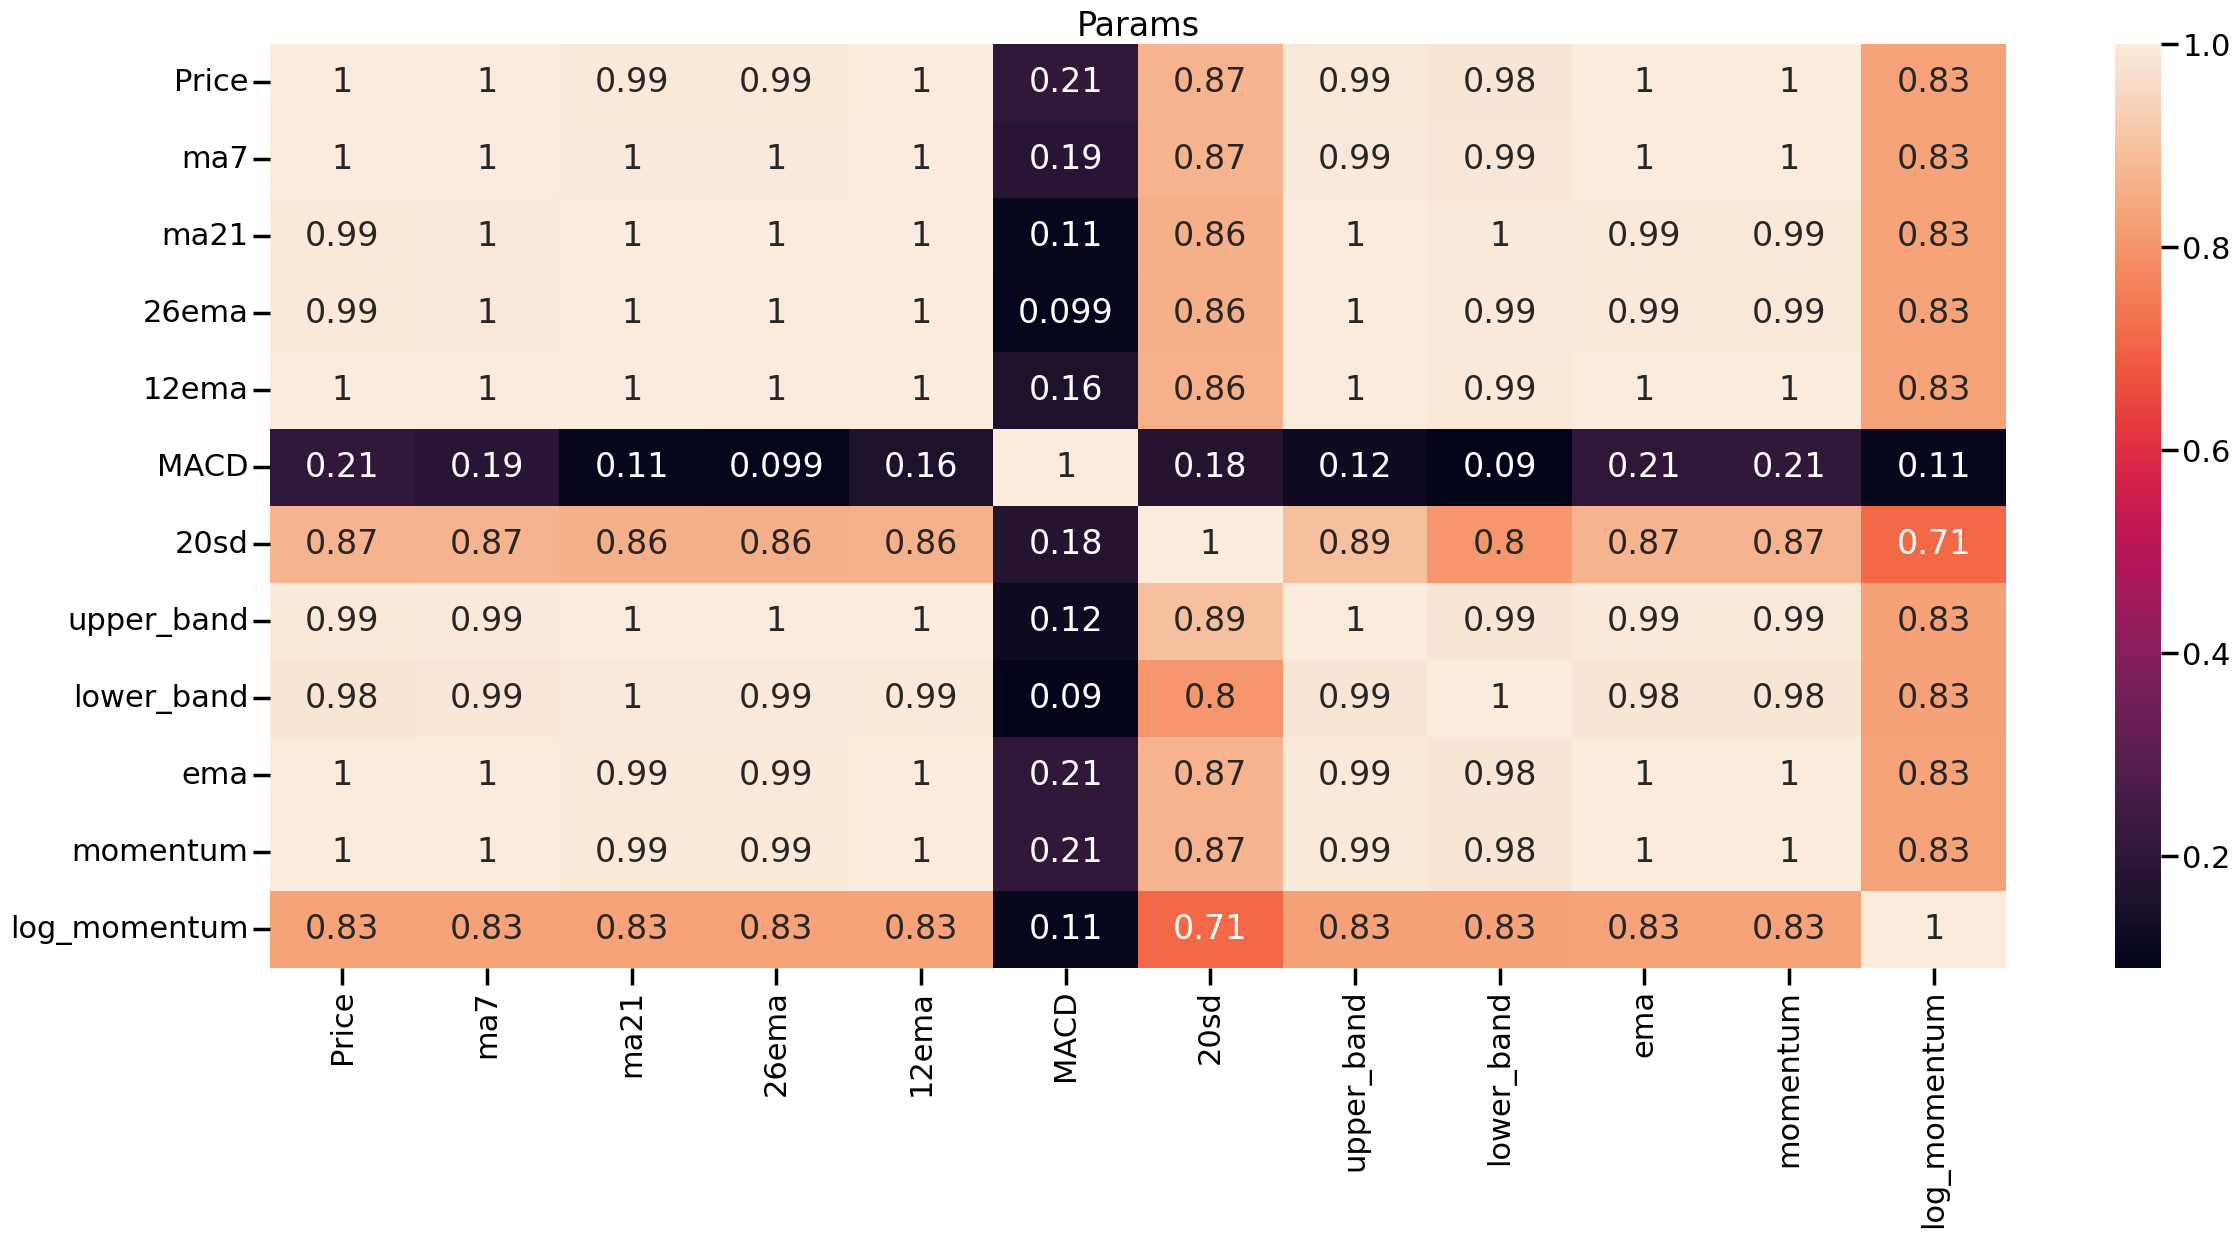

In [ ]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [ ]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3732 samples, and 12 features.


In [ ]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [ ]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2010-07-28,1.381333,1.381238,1.327460,1.340849,1.360547,0.019699,0.149731,1.626922,1.027999,1.380945,0.381333,-0.964082
2010-07-29,1.356667,1.381714,1.316222,1.342285,1.359935,0.017650,0.137159,1.590540,1.041904,1.364760,0.356667,-1.030953
2010-07-30,1.329333,1.379048,1.303873,1.341128,1.355124,0.013995,0.122269,1.548411,1.059335,1.341142,0.329333,-1.110686
2010-08-02,1.394667,1.378286,1.300571,1.345837,1.361320,0.015483,0.118611,1.537793,1.063350,1.376825,0.394667,-0.929713
2010-08-03,1.463333,1.384571,1.309302,1.356028,1.377259,0.021231,0.123660,1.556622,1.061981,1.434497,0.463333,-0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-21,334.619995,342.154288,302.446194,303.262815,324.173733,20.910919,31.686836,365.819866,239.072522,337.688539,333.619995,5.810003
2025-05-22,341.040009,343.150003,306.746194,306.061125,326.768545,20.707419,30.421024,367.588243,245.904146,339.922852,340.040009,5.829063
2025-05-23,339.339996,341.958575,310.547622,308.526227,328.702614,20.176387,29.185960,368.919542,252.175702,339.534282,338.339996,5.824051


**Spliting the dataset into training (70%) and testing (30%) set**

In [ ]:
# Splitting data into training and testing
train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(train.shape)
print(test.shape)

In [ ]:
#data_training = df[df.index < '2019-01-31'].copy()
data_training = train.copy()
data_training

In [ ]:
#data_testing = df[df.index >= '2019-01-31'].copy()
data_testing = test.copy()
data_testing

In [ ]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(3632, 12)


array([[4.34522132e-04, 3.35413731e-04, 8.82705538e-05, ...,
        4.06622983e-04, 4.34522132e-04, 9.95031828e-02],
       [3.82993744e-04, 3.36480797e-04, 6.11692999e-05, ...,
        3.72139825e-04, 3.82993744e-04, 9.10641703e-02],
       [3.25891474e-04, 3.30506367e-04, 3.13884495e-05, ...,
        3.21821930e-04, 3.25891474e-04, 8.10018320e-02],
       ...,
       [8.99307864e-01, 9.81728284e-01, 9.83555508e-01, ...,
        9.32425489e-01, 8.99307864e-01, 9.86611558e-01],
       [8.69538912e-01, 9.74456718e-01, 9.93261433e-01, ...,
        9.01979274e-01, 8.69538912e-01, 9.82365119e-01],
       [8.41190498e-01, 9.64109455e-01, 1.00000000e+00, ...,
        8.72556610e-01, 8.41190498e-01, 9.78184008e-01]])

In [ ]:
X_train = []
y_train = []

In [ ]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((3572, 60, 12), (3572,))

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
regressor.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 60, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,961 (706.88 KB)

 Trainable params: 180,961 (706.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - loss: 0.0255
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - loss: 0.0038
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 0.0038
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - loss: 0.0036
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - loss: 0.0029
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.0036
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - loss: 0.0029
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 0.0029
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - loss: 0.0027
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - loss: 0.0022
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 0.0027
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - loss: 0.0023
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - loss: 0.0023
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - loss: 0.0023
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 

In [ ]:
regressor.save('keras_model.h5')

In [ ]:
import pandas as pd
print(pd.__version__)        # simple version string

#dt = data_training.append(data_testing, ignore_index = True)
past_60 = data_training.tail(60)
dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

2.2.2


,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,1.381333,1.381238,1.327460,1.340849,1.360547,0.019699,0.149731,1.626922,1.027999,1.380945,0.381333,-0.964082
1,1.356667,1.381714,1.316222,1.342285,1.359935,0.017650,0.137159,1.590540,1.041904,1.364760,0.356667,-1.030953
2,1.329333,1.379048,1.303873,1.341128,1.355124,0.013995,0.122269,1.548411,1.059335,1.341142,0.329333,-1.110686
3,1.394667,1.378286,1.300571,1.345837,1.361320,0.015483,0.118611,1.537793,1.063350,1.376825,0.394667,-0.929713
4,1.463333,1.384571,1.309302,1.356028,1.377259,0.021231,0.123660,1.556622,1.061981,1.434497,0.463333,-0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...
3727,334.619995,342.154288,302.446194,303.262815,324.173733,20.910919,31.686836,365.819866,239.072522,337.688539,333.619995,5.810003
3728,341.040009,343.150003,306.746194,306.061125,326.768545,20.707419,30.421024,367.588243,245.904146,339.922852,340.040009,5.829063
3729,339.339996,341.958575,310.547622,308.526227,328.702614,20.176387,29.185960,368.919542,252.175702,339.534282,338.339996,5.824051
3730,362.890015,344.825718,314.259051,312.553174,333.962214,21.409040,30.685196,375.629442,252.888659,355.104770,361.890015,5.891340


In [ ]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(3732, 12)


array([[4.34522132e-04, 3.35413731e-04, 8.65589729e-05, ...,
        4.06622983e-04, 4.34522132e-04, 9.95031828e-02],
       [3.82993744e-04, 3.36480797e-04, 5.99832168e-05, ...,
        3.72139825e-04, 3.82993744e-04, 9.10641703e-02],
       [3.25891474e-04, 3.30506367e-04, 3.07798221e-05, ...,
        3.21821930e-04, 3.25891474e-04, 8.10018320e-02],
       ...,
       [7.06446820e-01, 7.63350894e-01, 7.31328058e-01, ...,
        7.20842009e-01, 7.06446820e-01, 9.56163654e-01],
       [7.55643968e-01, 7.69774325e-01, 7.40104817e-01, ...,
        7.54014922e-01, 7.55643968e-01, 9.64655512e-01],
       [7.43130520e-01, 7.71989075e-01, 7.48102318e-01, ...,
        7.56564737e-01, 7.43130520e-01, 9.62549168e-01]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((3672, 60, 12), (3672,))

In [ ]:
y_pred = regressor.predict(X_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step


In [ ]:
y_pred

array([[0.02459958],
       [0.02459531],
       [0.02459111],
       ...,
       [0.64079946],
       [0.6273752 ],
       [0.6207444 ]], dtype=float32)

In [ ]:
scale = 1/scalar.scale_[0]

In [ ]:
y_pred = y_pred*scale
y_test = y_test*scale

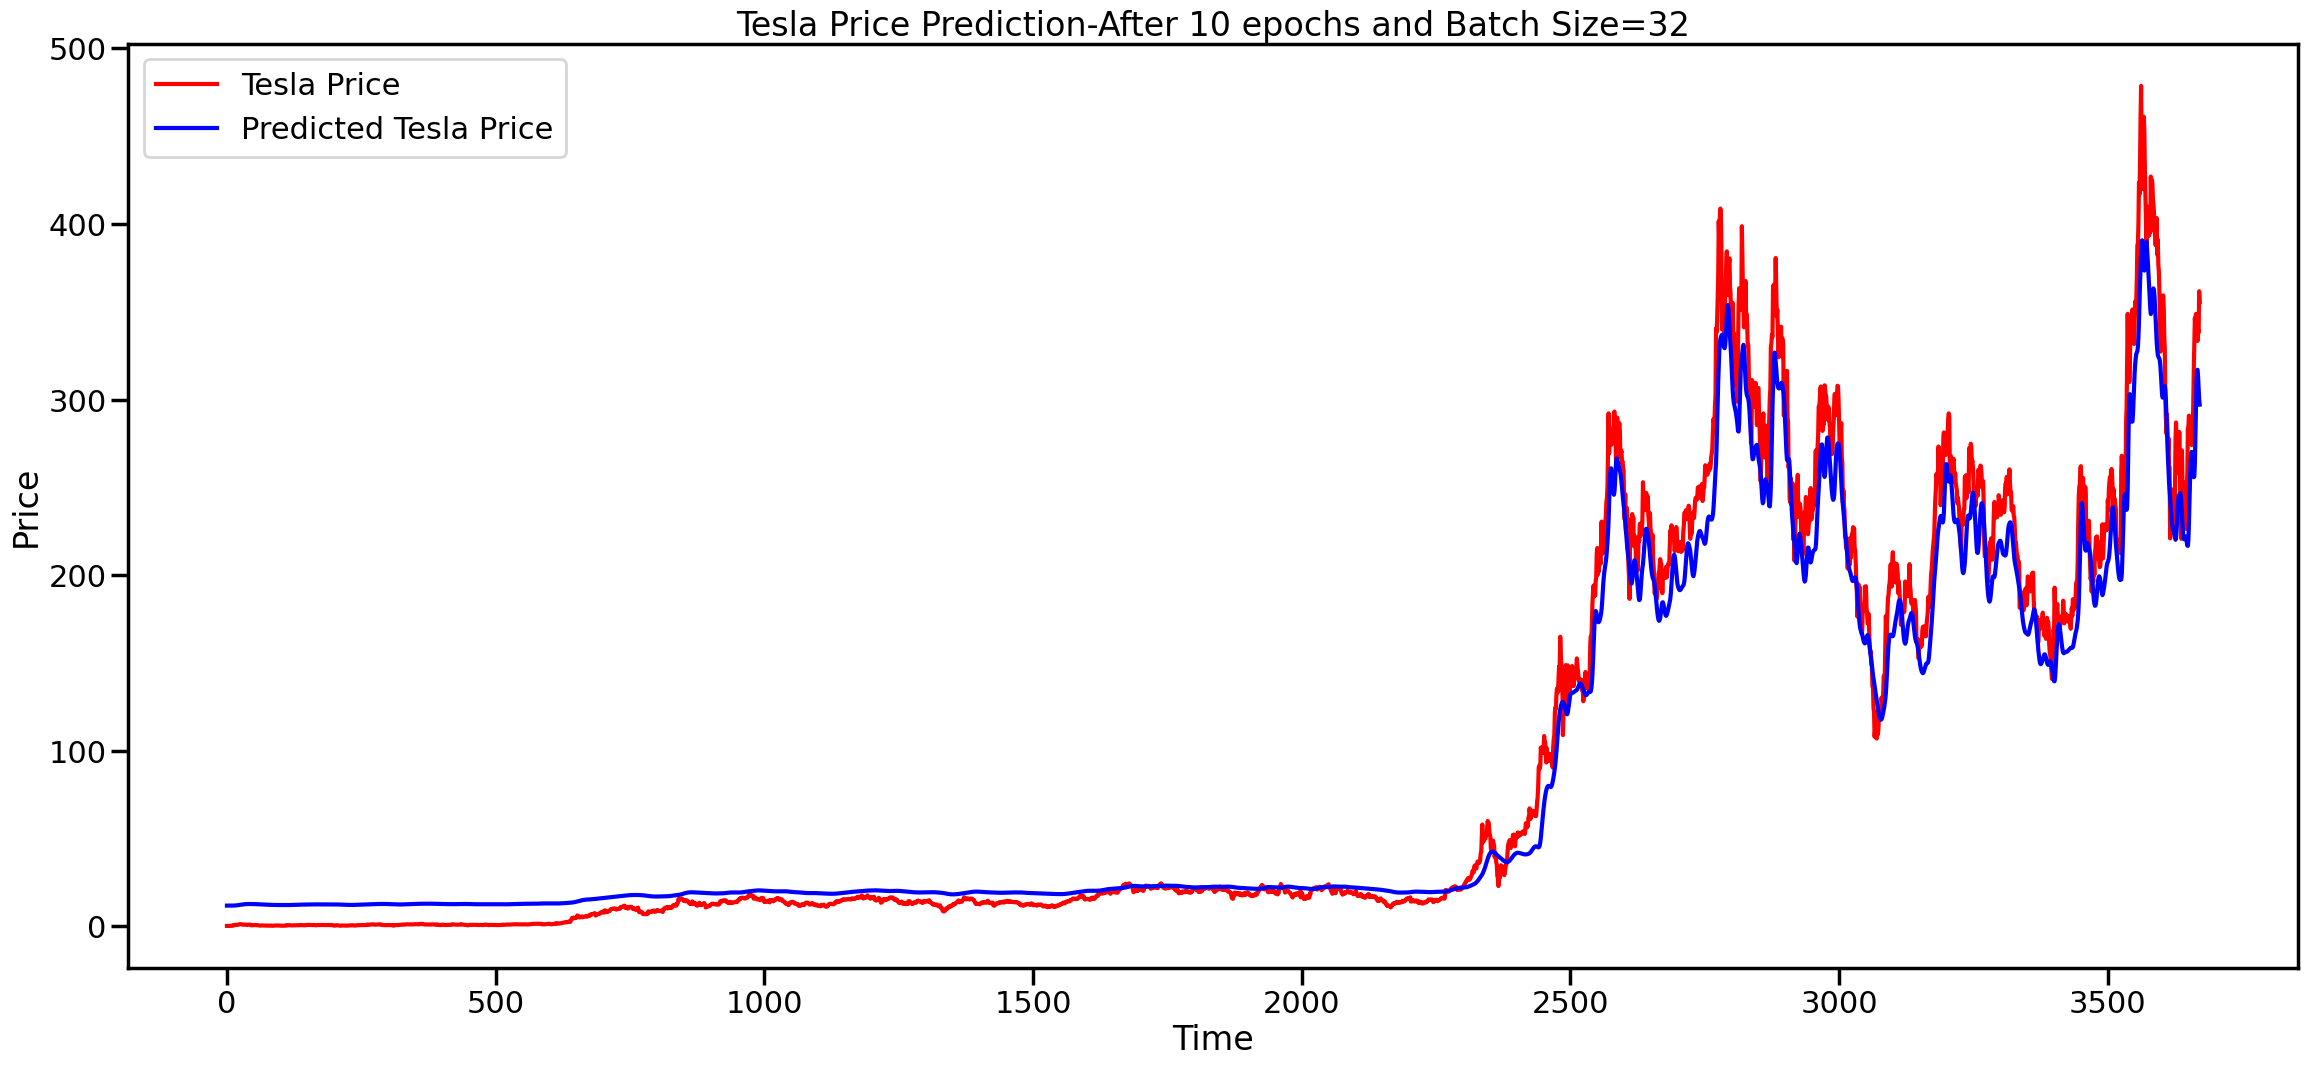

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

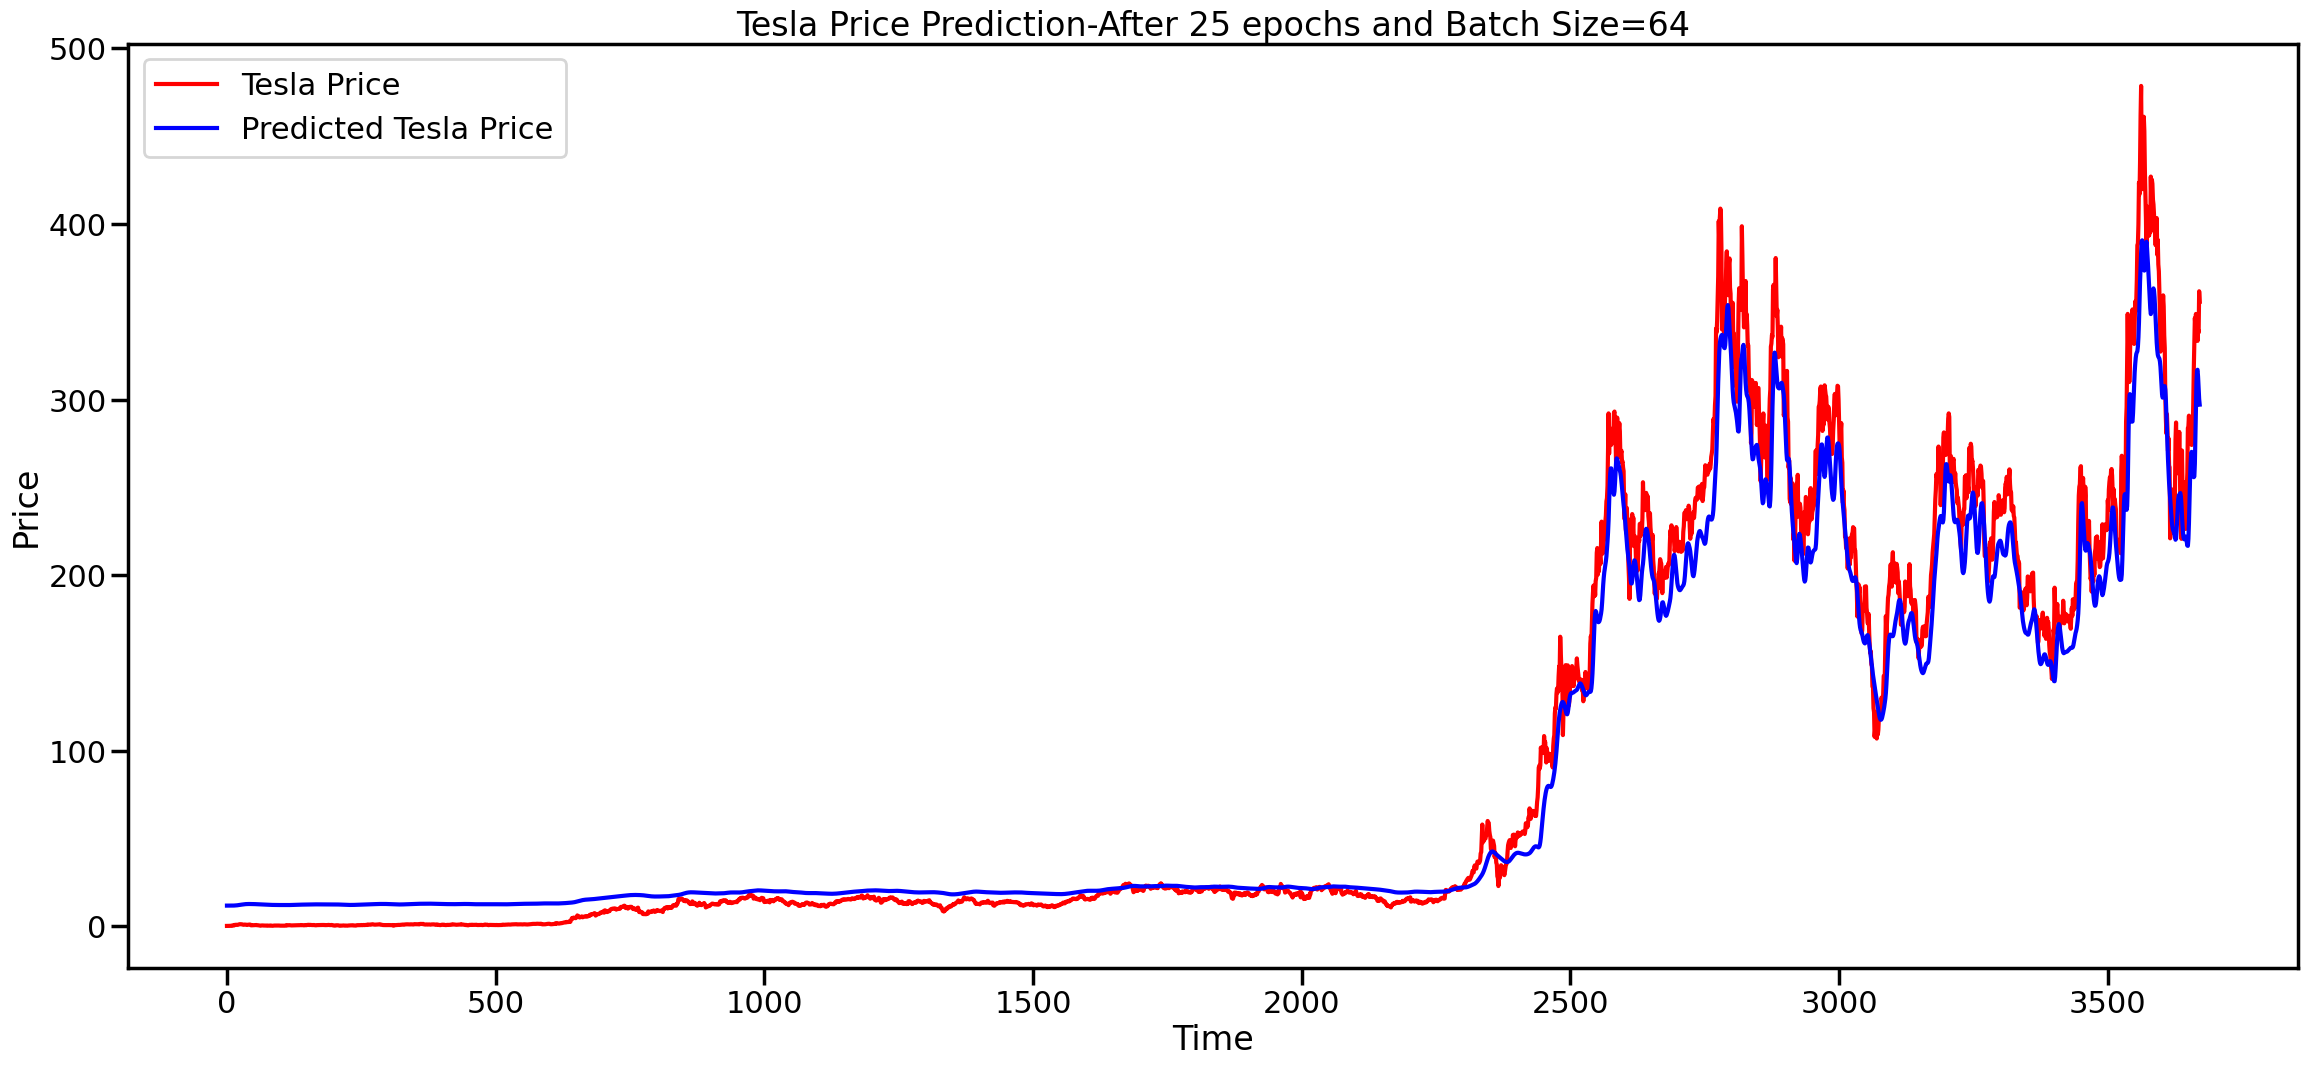

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

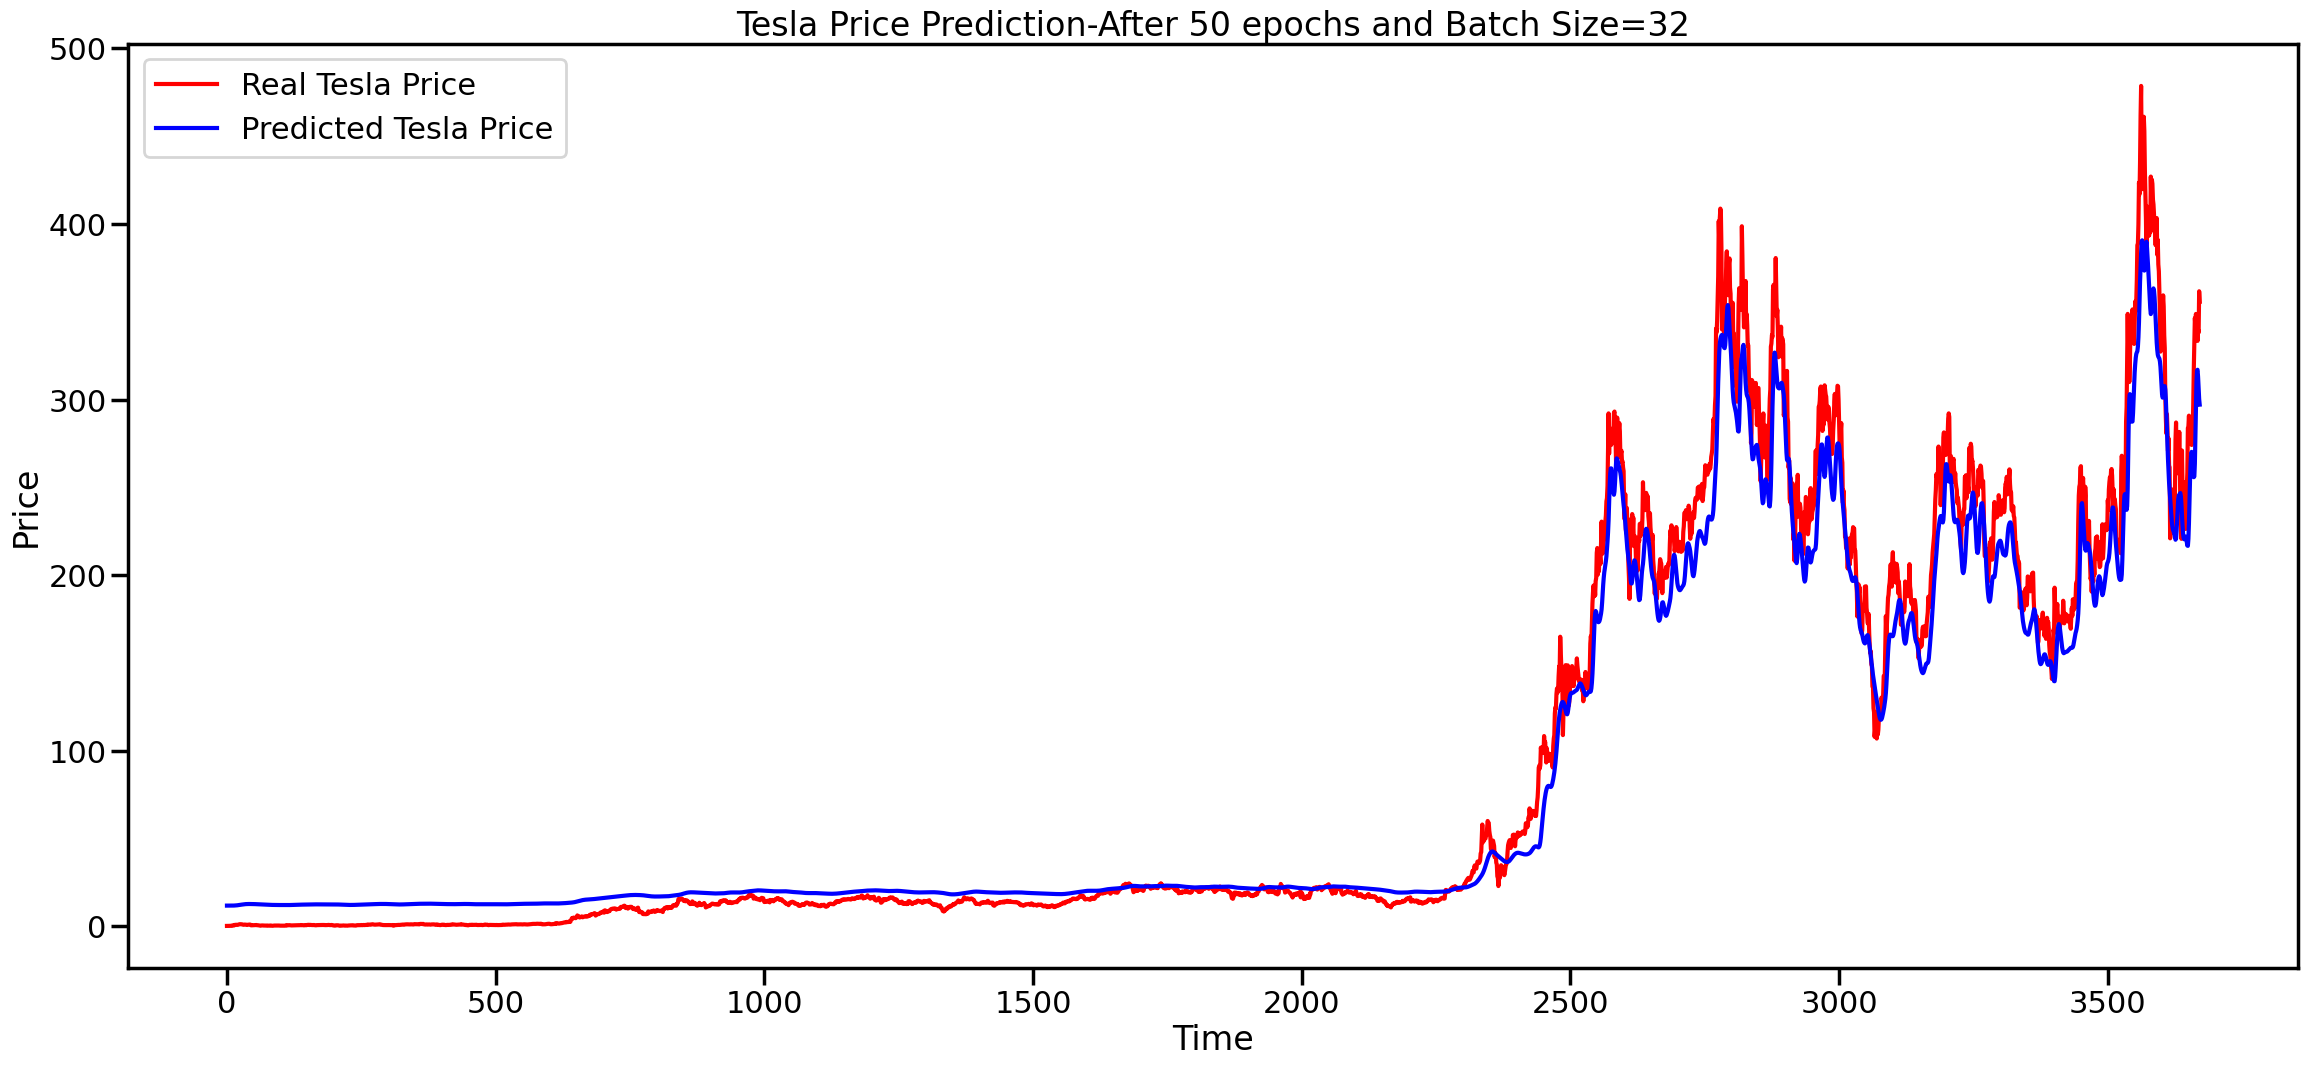

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Nvidia Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nvidia Price')
plt.title('Nvidia Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()